# CNN Image2Image - Colorization

### 1. Import Libraries and dataset

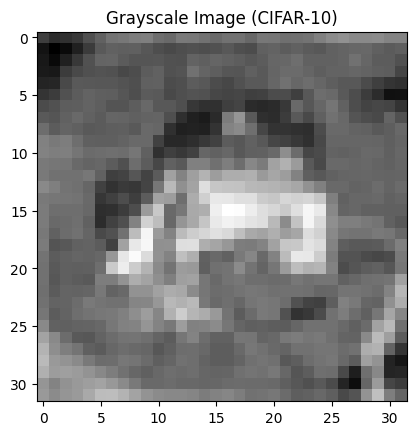

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
import tensorflow as tf

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the images to grayscale for colorization (only for the input)
x_train_gray = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
x_test_gray = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the grayscale images to have 1 channel (the model expects 3D input)
x_train_gray = np.expand_dims(x_train_gray, axis=-1)
x_test_gray = np.expand_dims(x_test_gray, axis=-1)

# Display an example grayscale image
plt.imshow(x_train_gray[0], cmap='gray')
plt.title("Grayscale Image (CIFAR-10)")
plt.show()

### 2. Define U-Net Model for Colorization

In [2]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (downsampling)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder (upsampling)
    up4 = layers.UpSampling2D((2, 2))(conv3)
    concat4 = layers.Concatenate()([up4, conv2])  # Skip connection
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D((2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv1])  # Skip connection
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer (3 channels for RGB)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    model = models.Model(inputs, outputs)
    return model

# Build the model with input shape for grayscale images (e.g., 32x32x1 for CIFAR-10)
input_shape = (32, 32, 1)
model = build_unet(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,882,115 (7.18 MB)

 Trainable params: 1,882,115 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Compile the Model

In [3]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### 4. Train the Model

In [4]:
# Train the model
model.fit(x_train_gray, x_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 589s 415ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 576s 410ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 571s 406ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 561s 399ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 561s 399ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 577s 410ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 614s 436ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 596s 424ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 586s 416ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 572s 407ms/step - loss: 0.0046 - val_loss: 0.0050


### 5. Evaluate and Visualize the Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


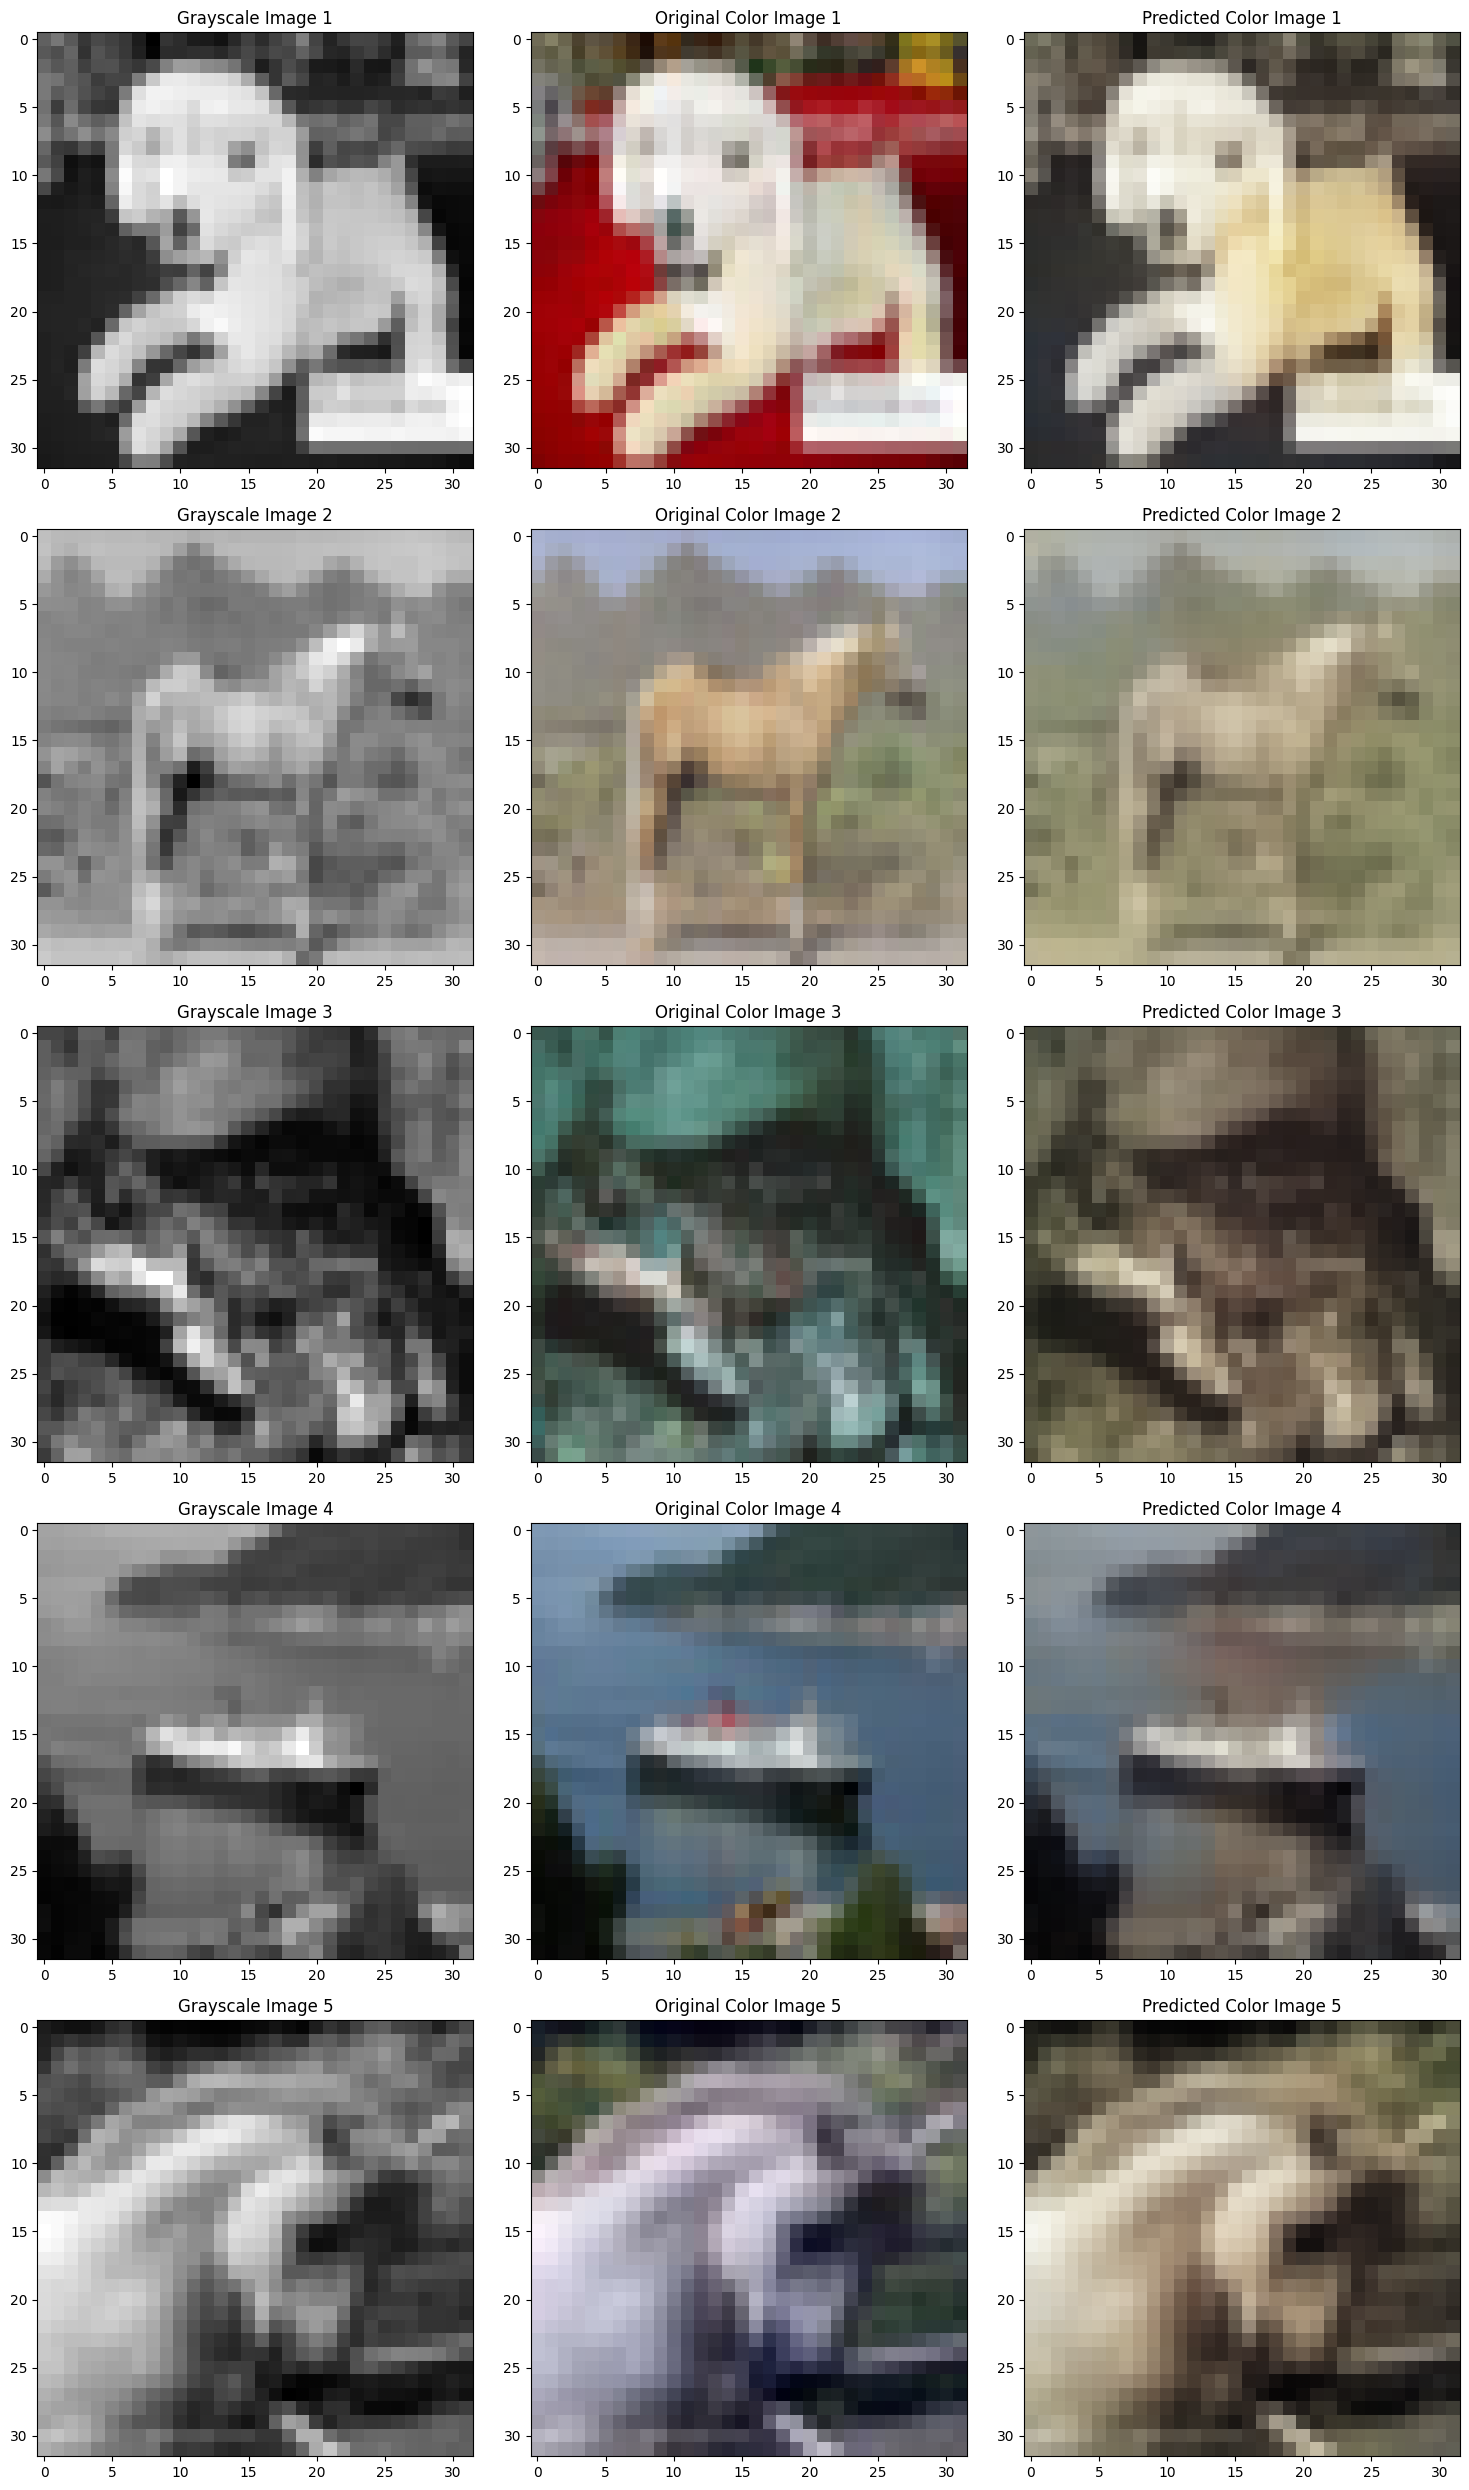

In [8]:
import random

# Function to visualize results for multiple random images
def visualize_random_results(x_gray, x_color, model, num_images=5):
    # Randomly select indices
    random_indices = random.sample(range(len(x_gray)), num_images)

    plt.figure(figsize=(15, 5 * num_images))

    for i, idx in enumerate(random_indices):
        grayscale_image = x_gray[idx]
        color_image = x_color[idx]
        
        # Predict the colorization
        predicted_image = model.predict(np.expand_dims(grayscale_image, axis=0))

        # Plot grayscale, original color, and predicted color images
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(grayscale_image.squeeze(), cmap='gray')
        plt.title(f'Grayscale Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(color_image)
        plt.title(f'Original Color Image {i+1}')
        
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predicted_image.squeeze())
        plt.title(f'Predicted Color Image {i+1}')

    plt.tight_layout()
    plt.show()

# Visualize 5 random images
visualize_random_results(x_test_gray, x_test, model, num_images=5)
